# SSEP Generator

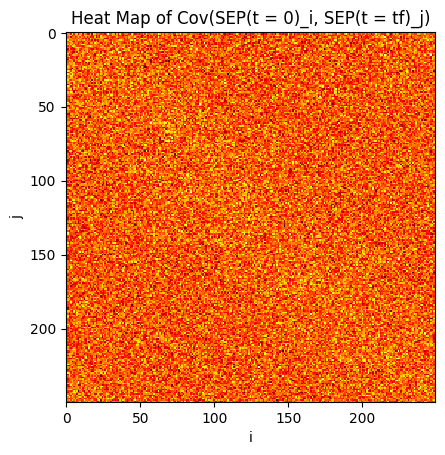

torch.Size([250, 250])


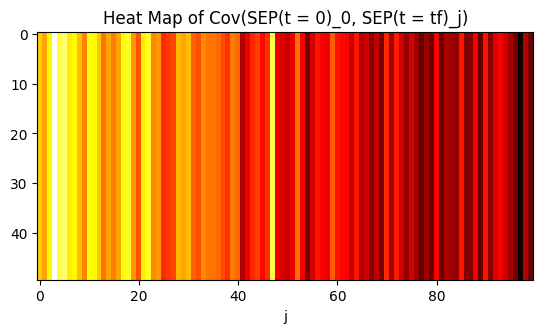

[ 2.48697703e-03  2.00948701e-03  3.04325111e-03  5.26158651e-03
  3.65032349e-03  4.06955648e-03  2.93139345e-03  3.08185909e-03
  2.34928261e-03  1.58205151e-03  3.17197060e-03  3.08075547e-03
  2.44704168e-03  1.37872237e-03  1.99504336e-03  1.50763418e-03
  2.02323310e-03  3.11112241e-03  3.50835687e-03  1.83675566e-03
  9.95971030e-04  2.96510523e-03  3.37298005e-03  1.65064330e-03
  1.88070675e-03  4.26211220e-04  6.77761738e-04  8.34354898e-04
  2.23946013e-03  2.04089703e-03  2.32366612e-03  1.14536216e-03
  9.28978203e-04  1.68011349e-03  1.39902427e-03  1.37096050e-03
  1.27344253e-03  8.52770987e-04  5.21984999e-04  1.51246437e-03
  1.25296193e-03 -1.02292444e-03 -3.15151177e-04  4.25392849e-04
  7.21537159e-04  4.71196690e-05  5.16737520e-04  3.68014467e-03
 -2.37246073e-04 -4.69535385e-04 -8.08398763e-04 -2.84157693e-04
  1.34528195e-03 -1.05965701e-04 -1.74017565e-03 -5.34861581e-04
  1.70322281e-04 -1.31630339e-04 -2.75517028e-04  1.13564916e-03
  1.88735910e-04  2.71857

In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from scipy import special


class SEPGenerator:
    # space size is the length of the grid
    # number of samples is how many processes we want to simulate in parallel (torch optimized)
    # time period is the number of seconds to run the SEP
    # right probability is probability a particle jumps to the right
    def __init__(self, space_size=250, num_samples=500, time_period=10, right_probability=0.5, inverse_density = 2):
        self.right_probability = right_probability
        self.space_size = space_size  # this is the size of the grid
        self.num_samples = num_samples  # number of games we are simulating at once  (i.e batch size)
        self.time_period = time_period  # number of total jumps by all particles
        self.inverse_density = inverse_density

        # all the data for the dataset (# of bits == samples * space size
        self.data = torch.zeros((self.num_samples, self.space_size), dtype=torch.bool)

        self.semi_random_initializer()

        #self.initializer()  # use a  simple initializers that initializes all the particles on one side

        self.num_particles = torch.sum(self.data, dim=-1, keepdim=True)  # number of particles in each sample

        # use fact that minimum of n mean 1 exponentials is a mean n exponential
        # this is the property behind poisson superposition
        self.exponential = torch.distributions.exponential.Exponential(self.num_particles.float(), validate_args=False)
        self.cumulative_time = torch.zeros_like(self.exponential.sample())
        # using a bernoulli distribution to generate the jump directions
        self.right_jump = torch.distributions.bernoulli.Bernoulli(probs=right_probability)

    # very basic half block initializer
    # initializer must assign the same amount of particles to each sample
    def initializer(self):
        self.data[:, self.space_size // 2:] = True

    def semi_random_initializer(self):
        x = np.arange(self.space_size)
        rng = np.random.default_rng()
        perms = rng.permuted(np.tile(x, self.num_samples).reshape(self.num_samples, x.size), axis=1)[:, :self.space_size//self.inverse_density]
        self.data[np.arange(self.num_samples).reshape(self.num_samples, 1), perms] = True

    def random_initializer(self):
        self.data = torch.rand_like(self.data, dtype=torch.float) < 1/self.inverse_density


    def restart_time(self):
        self.cumulative_time = torch.zeros_like(self.exponential.sample())

    def increment_time(self, time):
        self.time_period += time

    def step(self):
        new_wait_times = self.exponential.sample()
        self.cumulative_time += new_wait_times
        # mask out the processes that are done updating
        running_samples_indices = torch.nonzero(self.cumulative_time <= self.time_period).squeeze()
        hot_particles = torch.distributions.categorical.Categorical(probs=self.data.float() / self.num_particles)

        #todo watch out for nans
        initial_indices = hot_particles.sample()
        right_left_jump = (self.right_jump.sample(sample_shape=initial_indices.shape) * 2 - 1).to(torch.int64)

        # we want translational symmetry
        #final_indices = torch.clamp(initial_indices + right_left_jump, min=0, max=self.space_size - 1)
        final_indices = (initial_indices + right_left_jump) % self.space_size

        # update the particles following the SEP rule, making sure particles don't collide
        self.data[running_samples_indices, initial_indices[running_samples_indices]] = self.data[
            running_samples_indices, final_indices[running_samples_indices]]
        self.data[running_samples_indices, final_indices[running_samples_indices]] = 1

    def run(self):
        while (self.cumulative_time < self.time_period).any():
            self.step()

    # compute the fourier transform for the space of particles, this is another representation of tha data
    # it might show deterministic patterns in the low frequency components
    def fft(self):
        frequency_components = torch.fft.rfft(self.data.float(), dim=-1)
        return frequency_components.abs().float(), frequency_components.angle().float()

    def barcode_vizualization(self):
        plt.imshow(self.data.int().numpy() * 255)
        plt.show()

    def density_visualization(self):
        t = self.cumulative_time.mean()
        density = self.data.float().mean(dim=0)
        x = np.arange(self.data.shape[1]) / self.data.shape[1]
        function_fit = 0.5 * (1 + special.erf(self.space_size * (x-0.5)/np.sqrt(t)))
        plt.plot(x, density)
        plt.plot(x, function_fit)
        plt.title("density at t = " + str(t.item()))
        plt.show()

if __name__ == '__main__':
    gen = SEPGenerator(time_period=1600)
    initial_state = None
    final_state = None
    initial_state = gen.data.clone()
    '''
    for i in range(20):
        #gen.barcode_vizualization()
        #gen.density_visualization()
        gen.run()  # run x seconds of SEP
        #gen.restart_time()  # restart internal timer so we can run more seconds
        gen.increment_time(10)
    '''
    gen.run()
    final_state = gen.data.clone()

    initial_state = initial_state.view(gen.num_samples, 250, 1)
    final_state = final_state.view(gen.num_samples, 1, 250)
    big_covariance_matrix = (initial_state.float() @ final_state.float()).mean(dim=0) - initial_state.float().mean(dim=0) @ final_state.float().mean(dim=0)

    import matplotlib.pyplot as plt

    plt.imshow(big_covariance_matrix, cmap='hot', interpolation='nearest')
    plt.title('Heat Map of Cov(SEP(t = 0)_i, SEP(t = tf)_j)')
    plt.xlabel('i')
    plt.ylabel('j')
    plt.show()

    print(big_covariance_matrix.shape)
    offset_covariance = np.zeros(250)
    import math
    for i in range(250):
        for j in range(250):
            offset_covariance[abs(j-i)] += big_covariance_matrix[i, j]/250

    plt.title('Heat Map of Cov(SEP(t = 0)_0, SEP(t = tf)_j)')
    plt.imshow(np.tile(offset_covariance[:100], (50, 1)), cmap='hot', interpolation='nearest')
    plt.xlabel('j')
    plt.show()

    print(offset_covariance)
